In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast

import sys
print('sys.executable =', sys.executable)
import importlib
print('keybert spec =', importlib.util.find_spec('keybert'))
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
import seaborn as sns
from keybert import KeyBERT

# Load dataset
df = pd.read_csv("Uitgebreide_VKM_dataset.csv")

# Display first few rows
print(df.head())

sys.executable = c:\Users\tjeer\anaconda3\python.exe
keybert spec = ModuleSpec(name='keybert', loader=<_frozen_importlib_external.SourceFileLoader object at 0x00000140C8A001D0>, origin='c:\\Users\\tjeer\\anaconda3\\Lib\\site-packages\\keybert\\__init__.py', submodule_search_locations=['c:\\Users\\tjeer\\anaconda3\\Lib\\site-packages\\keybert'])
    id                          name  \
0  159  Kennismaking met Psychologie   
1  160   Learning and working abroad   
2  161       Proactieve zorgplanning   
3  162               Rouw en verlies   
4  163           Acuut complexe zorg   

                                    shortdescription  \
0  Brein, gedragsbeinvloeding, ontwikkelingspsych...   
1  Internationaal, persoonlijke ontwikkeling, ver...   
2     Proactieve zorgplanning, cocreatie, ziekenhuis   
3  Rouw & verlies, palliatieve zorg & redeneren, ...   
4  Acute zorg, complexiteit, ziekenhuis, revalidatie   

                                         description  \
0  In deze module l

In [6]:
df.columns = df.columns.str.strip()
print(df.columns)

Index(['id', 'name', 'shortdescription', 'description', 'content',
       'studycredit', 'location', 'contact_id', 'level', 'learningoutcomes',
       'Rood', 'Groen', 'Blauw', 'Geel', 'module_tags',
       'interests_match_score', 'popularity_score', 'estimated_difficulty',
       'available_spots', 'start_date'],
      dtype='object')


In [10]:
# Make a copy of the DataFrame
df_copy = df.copy()

# Normalize the 'popularity_score' column from 0–500 to 0–1
df_copy['popularity_score'] = df_copy['popularity_score'] / 500

# remove the color columns if
colorCols = ['Rood', 'Geel', 'Blauw', 'Groen']
if([col for col in colorCols if col in df_copy.columns]):
    df_copy = df_copy.drop(columns=colorCols)

# # Fill empty (NaN or blank) values in 'module_tags' with ['ntb']
# df_copy['module_tags'] = df_copy['module_tags'].apply(
#     lambda x: ['ntb'] if (pd.isna(x) or (isinstance(x, str) and x.strip() == '')) else x
# )

# Update short_description
def update_short_description(row):
    desc = str(row.get('description', '')).strip()
    cont = str(row.get('content', '')).strip()
    short = str(row.get('shortdescription', '')).strip()

    # Only change when short_description == 'Ntb'
    if short.lower() == 'ntb' or short.lower() == 'nan':
        # If description or content is also 'ntb', keep 'Ntb'
        if desc.lower() == 'ntb' or cont.lower() == 'ntb':
            return 'Ntb'
        else:
            return f"{desc} {cont}".strip()
    return short

df_copy['shortdescription'] = df_copy.apply(update_short_description, axis=1)


# --- Clean up the learningoutcomes column ---
df_copy['learningoutcomes'] = df_copy['learningoutcomes'].replace(
    {
        r'(?i)^(ntb|n\.t\.b\.|n\.n\.b\.|volgt|nog nader te bepalen|nog te formuleren|nog niet bekend|nog te bepalen|\s*)$':
        'Nog te bepalen'
    },
    regex=True
)

# Also handle NaN (missing) values
df_copy['learningoutcomes'] = df_copy['learningoutcomes'].fillna('Nog te bepalen')

def is_empty_tag(value):
    """Check of een tag waarde leeg of ntb is"""
    # Check voor None/NaN (maar niet voor arrays)
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return True
    
    if isinstance(value, str):
        v = value.strip()
        if v == "" or v == "[]" or v.lower() in ["['ntb']", "ntb"]:
            return True
        
        # Probeer te parsen als lijst
        try:
            parsed = ast.literal_eval(v)
            if isinstance(parsed, list):
                if len(parsed) == 0:
                    return True
                if len(parsed) == 1 and str(parsed[0]).lower() == "ntb":
                    return True
        except:
            pass
    
    if isinstance(value, list):
        if len(value) == 0:
            return True
        if len(value) == 1 and str(value[0]).lower() == "ntb":
            return True
    
    return False

def extract_keywords_from_text(text, model):
    """Extraheer keywords uit tekst met KeyBERT"""
    if not isinstance(text, str) or not text.strip():
        return []
    
    try:
        keywords = model.extract_keywords(
            text, 
            keyphrase_ngram_range=(1, 2)
        )
        return [keyword[0] for keyword in keywords]
    except:
        return []

# Check of er lege tags zijn die gevuld moeten worden
if 'module_tags' in df_copy.columns:
    # Veiligere manier om empty mask te maken
    empty_mask = []
    for idx, value in df_copy['module_tags'].items():
        empty_mask.append(is_empty_tag(value))
    
    empty_mask = pd.Series(empty_mask, index=df_copy.index)
    rows_to_process = empty_mask.sum()
    
    if rows_to_process > 0:
        print(f"Gevonden {rows_to_process} rijen met lege/ontbrekende tags")
        print("Start keyword extractie...")
        
        # Initialiseer KeyBERT model (alleen als nodig)
        kw_model = KeyBERT()
        
        # Maak combined text kolom (alleen als niet bestaat)
        if 'combined_text' not in df_copy.columns:
            df_copy['combined_text'] = (
                df_copy['description'].fillna('') + " " + 
                df_copy['content'].fillna('')
            )
        
        # Genereer nieuwe tags alleen voor lege rijen
        def generate_tags_if_empty(row):
            if is_empty_tag(row['module_tags']):
                return extract_keywords_from_text(row['combined_text'], kw_model)
            else:
                # Bestaande tags behouden, converteer string naar lijst indien nodig
                current = row['module_tags']
                if isinstance(current, str):
                    try:
                        return ast.literal_eval(current)
                    except:
                        return [current]
                return current
        
        # Update alleen de lege tags
        df_copy['module_tags'] = df_copy.apply(generate_tags_if_empty, axis=1)
        
        print(f"Tags gegenereerd voor {rows_to_process} modules")
        
        # Toon resultaten
        updated_rows = df_copy[empty_mask][['name', 'module_tags']].head(5)
        print("\nVoorbeelden van gegenereerde tags:")
        for idx, row in updated_rows.iterrows():
            print(f"- {row['name']}: {row['module_tags']}")
    else:
        print("Alle modules hebben al tags - geen actie nodig")
else:
    print("Kolom 'module_tags' niet gevonden in dataset")

# create new csv
df_copy.to_csv("Uitgebreide_VKM_dataset_cleaned.csv", index=False)

# Verify the change
display(df_copy)


Gevonden 30 rijen met lege/ontbrekende tags
Start keyword extractie...
Tags gegenereerd voor 30 modules

Voorbeelden van gegenereerde tags:
- Oncologie: ['oncologische ziektebeelden', 'oncologische zorg', 'naasten oncologie', 'oncologische', 'zorgvragers en']
- Pro-active nursing: ['active nursing', 'nursing', 'een professionele', 'nursing leer', 'professionele beoordeling']
- Jongeren en actuele problematiek: ['problematiek te', 'actuele problematiek', 'en huiselijk', 'huiselijk geweld', 'waar het']
- Management in de zorg: ['kwaliteitsmanagement zorgsector', 'en kwaliteitsmanagement', 'management kwaliteitsmanagement', 'kwaliteitsmanagement en', 'management zorg']
- Gedrag: ['verbinding van', 'trainingen sterk', 'leerkracht verbinding', 'gedrag van', 'orthopedagogiek trainingen']


,id,name,shortdescription,description,content,studycredit,location,contact_id,level,learningoutcomes,module_tags,interests_match_score,popularity_score,estimated_difficulty,available_spots,start_date,combined_text
0,159,Kennismaking met Psychologie,"Brein, gedragsbeinvloeding, ontwikkelingspsych...",In deze module leer je hoe je gedrag van jezel...,In deze module leer je hoe je gedrag van jezel...,15,Den Bosch,58,NLQF5,A. Je beantwoordt vragen in een meerkeuze kenn...,"[brein, gedragsbeinvloeding, ontwikkelingspsyc...",0.54,0.638,1,79,2025-12-24,In deze module leer je hoe je gedrag van jezel...
1,160,Learning and working abroad,"Internationaal, persoonlijke ontwikkeling, ver...",Studenten kiezen binnen de (stam) van de oplei...,Studenten kiezen binnen de (stam) van de oplei...,15,Den Bosch,58,NLQF5,De student toont professioneel gedrag conform ...,"[internationaal, persoonlijke, ontwikkeling, v...",0.92,0.344,5,56,2025-12-20,Studenten kiezen binnen de (stam) van de oplei...
2,161,Proactieve zorgplanning,"Proactieve zorgplanning, cocreatie, ziekenhuis",Het Jeroen Bosch ziekenhuis wil graag samen me...,Het Jeroen Bosch ziekenhuis wil graag samen me...,15,Den Bosch,59,NLQF5,De student past pro actieve zorgplanning toe b...,"[proactieve, zorgplanning, cocreatie, ziekenhuis]",0.78,0.434,5,55,2025-09-23,Het Jeroen Bosch ziekenhuis wil graag samen me...
3,162,Rouw en verlies,"Rouw & verlies, palliatieve zorg & redeneren, ...",In deze module wordt stil gestaan bij rouw en ...,In deze module wordt stil gestaan bij rouw en ...,30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfsta...,"[rouw, verlies, palliatieve, zorg, redeneren, ...",0.69,0.908,1,54,2025-10-25,In deze module wordt stil gestaan bij rouw en ...
4,163,Acuut complexe zorg,"Acute zorg, complexiteit, ziekenhuis, revalidatie",In deze module kunnen studenten zich verdiepen...,In deze module kunnen studenten zich verdiepen...,30,Den Bosch,58,NLQF6,De student regisseert en voert (deels) zelfsta...,"[acute, zorg, complexiteit, ziekenhuis, revali...",0.40,0.356,5,38,2025-11-19,In deze module kunnen studenten zich verdiepen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,393,Ethiek & kritisch denken,"ethiek, filosofie, kritisch denken, ethisch ha...",Ethiek en ethisch handelen wordt steeds belang...,Ethiek en ethisch handelen wordt steeds belang...,30,Breda en Den Bosch,124,NLQF6,De student demonstreert persoonlijke groei op ...,"[ethiek, filosofie, kritisch, denken, ethisch,...",0.37,0.496,5,32,2025-10-17,Ethiek en ethisch handelen wordt steeds belang...
207,394,Avans Innovative Studio Junior,"persoonlijke ontwikkeling, interdisciplinair, ...",Je leert hoe welke waarde jouw werk heeft. Hoe...,Je leert hoe welke waarde jouw werk heeft. Hoe...,15,Breda,92,NLQF6,De student demonstreert persoonlijke groei op ...,"[persoonlijke, ontwikkeling, interdisciplinair...",0.73,0.598,5,62,2025-09-01,Je leert hoe welke waarde jouw werk heeft. Hoe...
208,395,Avans Innovative Studio Senior,Ook heb je de mogelijkheid om met creatieve on...,Ook heb je de mogelijkheid om met creatieve on...,Ook heb je de mogelijkheid om met creatieve on...,30,Breda,92,NLQF6,De student demonstreert persoonlijke groei op ...,"[mogelijkheid om, mogelijkheid, het werkveld, ...",0.30,0.210,5,62,2025-11-29,Ook heb je de mogelijkheid om met creatieve on...
209,396,Succesvol managen van een project,"Project Evaluatie, Scrum, Planning, Agile, Pri...","Leren om succesvol een project (innovatie, cha...","Leren om succesvol een project (innovatie, cha...",15,Breda,125,NLQF5,"1) Inzicht/kennis in de diverse factoren, zoal...","[project, evaluatie, scrum, planning, agile, p...",0.40,0.270,5,67,2025-09-14,"Leren om succesvol een project (innovatie, cha..."


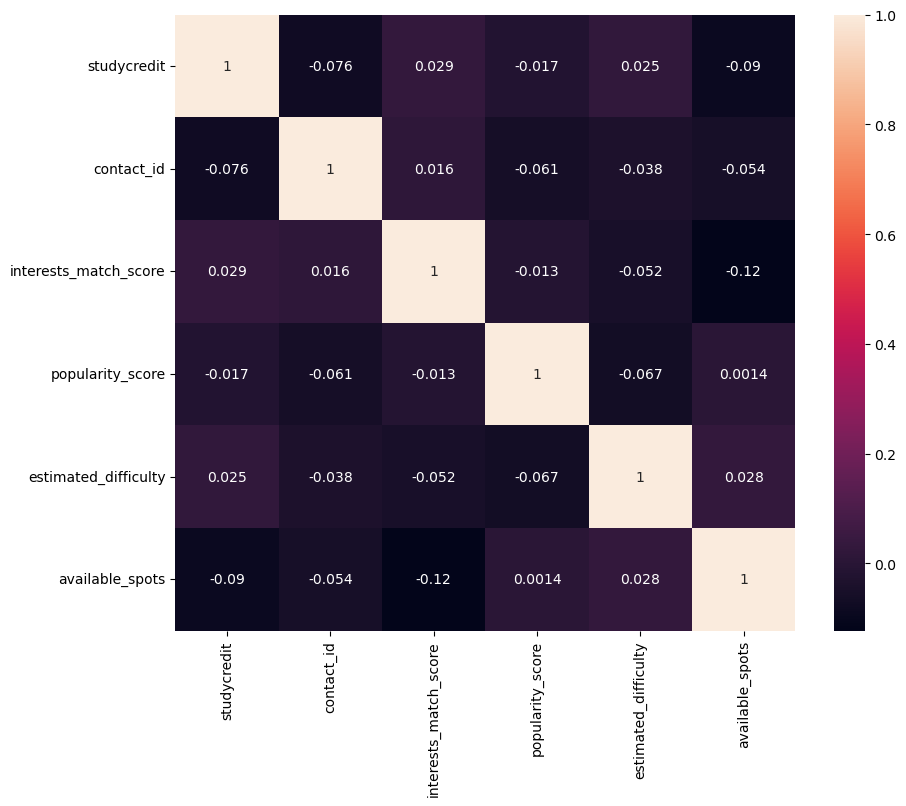

In [8]:
# df[['studycredit', 'contact_id', 'interests_match_score', 'popularity_score', 'estimated_difficulty', 'available_spots']].corr()
# make heatmap with pearson correlation
plt.figure(figsize=(10, 8))
sns.heatmap(df[['studycredit', 'contact_id', 'interests_match_score', 'popularity_score', 'estimated_difficulty', 'available_spots']].corr(method='pearson'), annot=True)
plt.show()

In [25]:
# # check for correlation between all cat the colums and the popularity_score
# # categorical_columns = df.select_dtypes(include=['object', 'category']).columns
# # for col in categorical_columns:
# #     correlation = df[col].astype('category').cat.codes.corr(df['popularity_score'])
# #     print(f"Correlation between {col} and popularity_score: {correlation}")


# # check for correlation between all cat the colums and the popularity_score
# # categorical_columns = df.select_dtypes(include=['object', 'category']).columns
# # for col in categorical_columns:
# #     correlation = df[col].astype('category').cat.codes.corr(df['studycredit'])
# #     print(f"Correlation between {col} and studycredit: {correlation}")
# # # level and study credit have the highest correlation of 0.757

# # categorical_columns = df.select_dtypes(include=['object', 'category']).columns
# # for col in categorical_columns:
# #     correlation = df[col].astype('category').cat.codes.corr(df['popularity_score'])
# #     print(f"Correlation between {col} and popularity_score: {correlation}")
# # # content and popularity_score: 0.04735826999164022


# # categorical_columns = df.select_dtypes(include=['object', 'category']).columns
# # for col in categorical_columns:
# #     correlation = df[col].astype('category').cat.codes.corr(df['interests_match_score'])
# #     print(f"Correlation between {col} and interests_match_score: {correlation}")


# categorical_columns = df.select_dtypes(include=['object', 'category']).columns
# for col in categorical_columns:
#     correlation = df[col].astype('category').cat.codes.corr(df['estimated_difficulty'])
#     print(f"Correlation between {col} and estimated_difficulty: {correlation}")


categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
    correlation = df[col].astype('category').cat.codes.corr(df['available_spots'])
    print(f"Correlation between {col} and available_spots: {correlation}")




Correlation between name and available_spots: -0.06704617182811923
Correlation between shortdescription and available_spots: -0.10490181391187914
Correlation between description and available_spots: 0.019030342682683273
Correlation between content and available_spots: -0.0019621047138791104
Correlation between location and available_spots: 0.0016390913600315548
Correlation between level and available_spots: -0.017121449867342108
Correlation between learningoutcomes and available_spots: 0.014406096545068874
Correlation between module_tags and available_spots: 0.07167796603902725
Correlation between start_date and available_spots: -0.03440745587262414


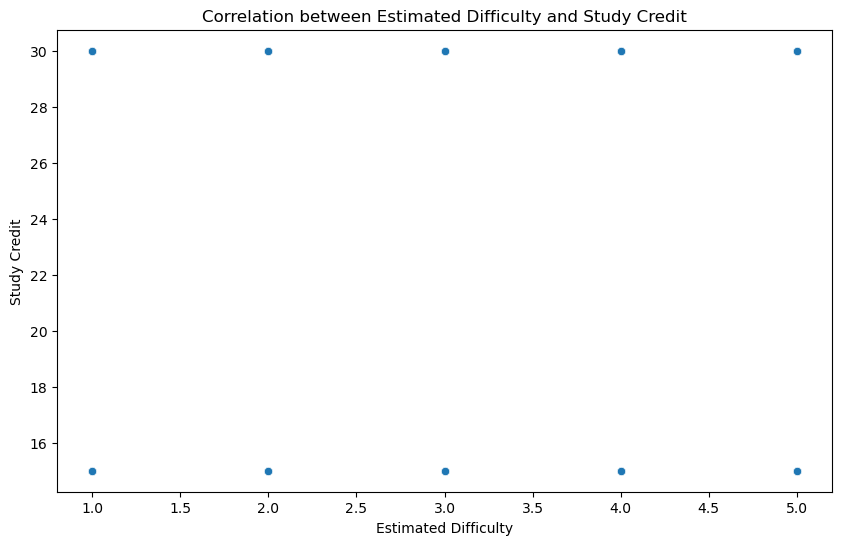

In [26]:
# make an graph to show the correlation between estimated_difficulty and studycredit
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='estimated_difficulty', y='studycredit')
plt.title('Correlation between Estimated Difficulty and Study Credit')
plt.xlabel('Estimated Difficulty')
plt.ylabel('Study Credit')
plt.show()